In [57]:
import os
import pickle
import logging

import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import numpyro
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi

from hbmep.config import Config
from hbmep.model.utils import Site as site

from hbmep_paper.utils import setup_logging
from models import MixedEffects
from constants import (
    DATA_PATH,
    TOML_PATH,
    INFERENCE_FILE,
    NETCODE_FILE,
    BUILD_DIR
)

logger = logging.getLogger(__name__)
setup_logging(dir=BUILD_DIR, fname="figure")
plt.rcParams["svg.fonttype"] = "none"


2024-04-02 12:50:53,498 - hbmep_paper.utils.utils - INFO - Logging to /home/vishu/repos/hbmep-paper/reports/intraoperative/midline-lateral/figure.log


In [58]:
M = MixedEffects

# Load posterior
dest = os.path.join(BUILD_DIR, M.NAME, INFERENCE_FILE)
with open(dest, "rb") as f:
    model, mcmc, posterior_samples_ = pickle.load(f)

posterior_samples = posterior_samples_.copy()
posterior_samples[site.outlier_prob] = 0 * posterior_samples[site.outlier_prob]

# Load data
df = pd.read_csv(DATA_PATH)
ind = ~df[model.response].isna().values.any(axis=-1)
df = df[ind].reset_index(drop=True).copy()
df[model.features[1]] = df[model.features[1]].replace({"L": "01_L", "M": "02_M"})
df, encoder_dict = model.load(df=df)


2024-04-02 12:50:54,042 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/intraoperative/midline-lateral/mixed_effects
2024-04-02 12:50:54,043 - hbmep.dataset.core - INFO - Processing data ...
2024-04-02 12:50:54,044 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [59]:
subset = [(7, 0), (7, 1), (12, 0), (12, 1)]
ind = df[model.features].apply(tuple, axis=1).isin(subset)
df = df[ind].reset_index(drop=True).copy()


In [60]:
prediction_df = model.make_prediction_dataset(df=df, num_points=5000)
posterior_predictive = model.predict(df=prediction_df, posterior_samples=posterior_samples)


2024-04-02 12:50:54,095 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.01 sec


2024-04-02 12:52:23,271 - hbmep.utils.utils - INFO - func:predict took: 1 min and 29.18 sec


In [61]:
a = posterior_samples[site.a]
a_map = a.mean(axis=0)
mu = posterior_predictive[site.mu]
obs = posterior_predictive[site.obs]
obs_hpdi = hpdi(obs, prob=.95)
a_random_mean = posterior_samples["a_random_mean"]


In [62]:
a_random_mean[:, 0, :].shape


(4000, 3)

In [66]:
hdi = az.hdi(a_random_mean[:, 0, :], hdi_prob=.95)
hdi

/tmp/ipykernel_1740575/3950645138.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(a_random_mean[:, 0, :], hdi_prob=.95)


array([[-0.40967865,  3.17879987],
       [ 0.7916328 ,  3.90512117],
       [ 1.11397658,  3.51651784]])

In [67]:
# Plot aesthetics
response_colors = {
    0: {
        0: (0.7216, 0.8824, 0.5255),
        1: (0.9451, 0.7137, 0.8549),
        2: (0.6706, 0.8510, 0.9137)
    },
    1: {
        0: (0.3020, 0.6745, 0.1490),
        1: (0.8157, 0.1098, 0.5451),
        2: (0.1725, 0.4824, 0.7137)
    }
}
prior_color = (.7, .7, .7)
cmap = sns.color_palette("tab10")
axis_label_size = 10


2024-04-02 13:56:52,811 - __main__ - INFO - Saved figure to /home/vishu/repos/hbmep-paper/reports/intraoperative/midline-lateral/midline-lateral.png


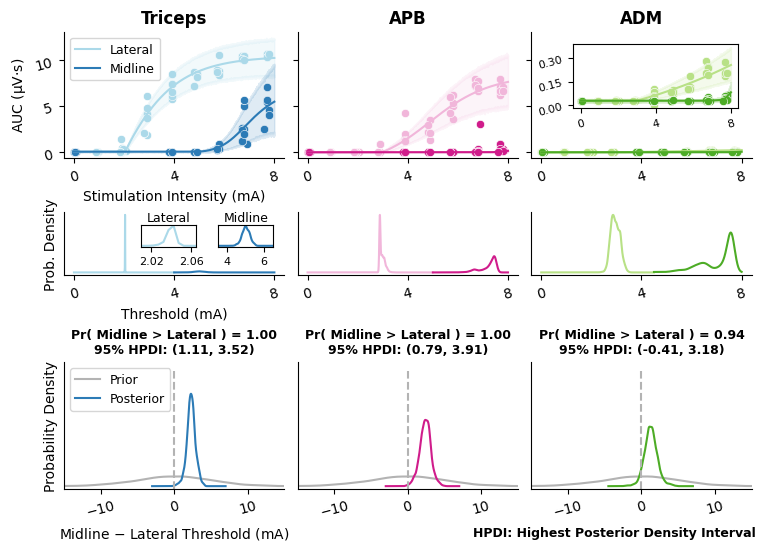

In [100]:
response = ['Triceps', 'APB', 'ADM']

# Plot
nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.5 * ncols, 1.8 * nrows), squeeze=False, height_ratios=[1, .5, 1], constrained_layout=True)

for muscle_ind in range(model.n_response):
    for side in [0, 1]:
        c = (7, side)
        if side == 0: lab = "Lateral"
        if side == 1: lab = "Midline"
        color = response_colors[side][muscle_ind]

        ind = df[model.features].apply(tuple, axis=1).isin([c])
        temp_df = df[ind].reset_index(drop=True).copy()

        pred_ind = prediction_df[model.features].apply(tuple, axis=1).isin([c])
        temp_pred_df = prediction_df[pred_ind].reset_index(drop=True).copy()

        temp_obs = obs[:, pred_ind, muscle_ind]
        temp_mu = mu[:, pred_ind, muscle_ind]
        temp_obs_hpdi = obs_hpdi[:, pred_ind, muscle_ind]

        ax = axes[0, - muscle_ind + 2]
        sns.scatterplot(x=temp_df[model.intensity], y=temp_df[model.response[muscle_ind]], ax=ax, color=color)
        sns.lineplot(x=temp_pred_df[model.intensity], y=temp_mu.mean(axis=0), color=color, ax=ax, label=lab)
        ax.fill_between(
            temp_pred_df[model.intensity],
            temp_obs_hpdi[0, :],
            temp_obs_hpdi[1, :],
            color=color,
            alpha=.15
        )
        ax.sharex(axes[0, 0])
        ax.sharey(axes[0, 0])

        ax = axes[1, - muscle_ind + 2]
        # sns.kdeplot(a[:, *c, muscle_ind], ax=ax, color=color)
        x_grid = temp_pred_df[model.intensity].values
        if side == 0:
            match muscle_ind:
                case 0: x_grid_ind = x_grid < 4.5
                case 1: x_grid_ind = x_grid < 5
                case 2: x_grid_ind = x_grid < 4

        if side == 1:
            match muscle_ind:
                case 0: x_grid_ind = x_grid > 4.5
                case 1: x_grid_ind = x_grid > 5
                case 2: x_grid_ind = x_grid > 4

        x_grid = x_grid[x_grid_ind]
        kde = stats.gaussian_kde(a[:, *c, muscle_ind])
        density = kde(x_grid)
        ax.plot(x_grid, density, color=color)
        ax.sharex(axes[0, 0])
        # if muscle_ind == 2:
        #     ax.set_ylim(bottom=-2)

        if (side, muscle_ind) in [(0, 2), (1, 2)]:
            inset_ypos = 0.45
            inset_height = 0.35
            inset_width = 0.25
            match side:
                case 0:
                    ins = ax.inset_axes([0.3+.05,inset_ypos,inset_width, inset_height])
                    title = "Lateral"
                    x_grid = np.linspace(1.8, 2.3, 100)
                    xlims = (2.01, 2.065)
                    xticks = [2.02, 2.06]
                case 1:
                    ins = ax.inset_axes([0.65+.05,inset_ypos,inset_width, inset_height])
                    title = "Midline"
                    x_grid = np.linspace(3.5, 6.5, 100)
                    xlims = (3.5, 6.5)
                    xticks = [4, 6]

            kde = stats.gaussian_kde(a[:, *c, muscle_ind])
            density = kde(x_grid)
            ins.plot(x_grid, density, color=color)
            ins.set_xlabel("")
            ins.set_ylabel("")
            ins.set_xlim(*xlims)
            ins.set_xticks(xticks)
            ins.tick_params(
                axis='both',
                which='both',
                left=False,
                bottom=True,
                right=False,
                top=False,
                labelleft=False,
                labelbottom=True,
                labelright=False,
                labeltop=False,
                labelrotation=0,
                labelsize=8
            )
            ins.set_title(title, fontsize=9, pad=1)

    ax = axes[2, - muscle_ind + 2]
    samples = a_random_mean[:, 0, muscle_ind]
    d = dist.Normal(0, 5)
    prior = d.sample(model.rng_key, (10000, ))
    sns.kdeplot(prior, ax=ax, color=prior_color, label="Prior")
    # x_grid = np.linspace(-12, 12, 100)
    # kde = stats.gaussian_kde(prior)
    # density = kde(x_grid)
    # ax.plot(x_grid, density, color=prior_color, label="Prior")
    # sns.kdeplot(samples, ax=ax, color=response_colors[1][muscle_ind], label="Posterior")
    match muscle_ind:
        case 0: x_grid = np.linspace(-4.5, 7, 5000)
        case 1: x_grid = np.linspace(-3, 7, 5000)
        case 2: x_grid = np.linspace(-3, 7, 5000)
    kde = stats.gaussian_kde(samples)
    density = kde(x_grid)
    ax.plot(x_grid, density, color=response_colors[1][muscle_ind], label="Posterior")
    prob = (samples > 0).mean()
    ax.set_title(f"Pr( Midline > Lateral ) = {prob:.2f}\n95% HPDI: ({hdi[muscle_ind, 0]:.2f}, {hdi[muscle_ind, 1]:.2f})", fontweight="bold", size=9)
    ax.sharex(axes[2, 0])
    ax.sharey(axes[2, 0])
    ax.axvline(x=0, color=prior_color, linestyle="--", ymax=.93)
    ax.set_xlim(left=-15, right=15)
    ax.set_ylim(bottom=-.02)

muscle_ind = 0
ax = axes[0, 2]
ins = ax.inset_axes([0.19,0.4,0.75 ,0.5])
for side in [0, 1]:
    c = (7, side)
    color = response_colors[side][muscle_ind]

    ind = df[model.features].apply(tuple, axis=1).isin([c])
    temp_df = df[ind].reset_index(drop=True).copy()

    pred_ind = prediction_df[model.features].apply(tuple, axis=1).isin([c])
    temp_pred_df = prediction_df[pred_ind].reset_index(drop=True).copy()

    temp_obs = obs[:, pred_ind, muscle_ind]
    temp_mu = mu[:, pred_ind, muscle_ind]
    temp_obs_hpdi = obs_hpdi[:, pred_ind, muscle_ind]

    sns.scatterplot(x=temp_df[model.intensity], y=temp_df[model.response[muscle_ind]], ax=ins, color=color)
    sns.lineplot(x=temp_pred_df[model.intensity], y=temp_mu.mean(axis=0), color=color, ax=ins)
    ins.fill_between(
        temp_pred_df[model.intensity],
        temp_obs_hpdi[0, :],
        temp_obs_hpdi[1, :],
        color=color,
        alpha=.15
    )
    ins.set_xlabel("")
    ins.set_ylabel("")
    ins.set_xticks([0, 4, 8])
    # ins.set_yticks([0, 0.2])
    ins.yaxis.set_major_locator(plt.MaxNLocator(3))
    ins.tick_params(
        axis='both',
        which='both',
        left=True,
        bottom=True,
        right=False,
        top=False,
        labelleft=True,
        labelbottom=True,
        labelright=False,
        labeltop=False,
        labelrotation=15,
        labelsize=8
    )

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        sides = ['right', 'top']
        for side in sides:
            ax.spines[side].set_visible(False)
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=False,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=15
        )
        ax.set_xlabel("")
        ax.set_ylabel("")

for muscle_ind in range(model.n_response):
    for side in [0, 1]:
        ax = axes[0, muscle_ind]
        ax.set_xlabel("Stimulation Intensity (mA)", size=axis_label_size)

        ax = axes[1, muscle_ind]
        ax.set_xlabel("Threshold (mA)", size=axis_label_size)
        ax.tick_params(
            axis='both',
            which='both',
            left=False,
            labelleft=False,
            labelrotation=15
        )

        ax = axes[2, muscle_ind]
        ax.set_xlabel("Midline $-$ Lateral Threshold (mA)", size=axis_label_size)
        ax.tick_params(
            axis='both',
            which='both',
            left=False,
            labelleft=False,
            labelrotation=15
        )

for i in range(nrows):
    for j in range(1, ncols):
        ax = axes[i, j]
        ax.set_xlabel("")

ax = axes[0, 0]
ax.tick_params(
    axis='both',
    which='both',
    labelleft=True,
    labelrotation=15
)
ax.set_ylabel("AUC (µV$\cdot$s)", size=axis_label_size)
ax.set_yticks([0, 5, 10])
ax.set_xticks([0, 4, 8])
ax.legend(loc="upper left", prop={'size': 9})

for j in range(1, 3):
    ax = axes[0, j]
    ax.get_legend().remove()


for j in range(3):
    ax = axes[0, j]
    ax.set_title(response[j], fontweight="bold")
    ax = axes[1, j]
    ax.tick_params(
        axis='both',
        which='both',
        left=False,
    )
    ax = axes[2, j]
    ax.tick_params(
        axis='both',
        which='both',
        left=False,
    )

ax = axes[1, 0]
ax.set_ylabel("Prob. Density", size=axis_label_size)

ax = axes[2, 0]
ax.tick_params(
    axis='both',
    which='both',
    left=True,
    labelleft=True,
    labelbottom=True,
    labelrotation=15
)
ax.tick_params(
    axis='both',
    which='both',
    left=False,
    labelleft=False,
    labelbottom=True,
    labelrotation=15
)
ax.set_ylabel("Probability Density", size=axis_label_size)
ax.set_xticks([-10, 0, 10])
ax.set_yticks([0., 0.4, 0.8])
ax.legend(loc="upper left", prop={'size': 9})

fig.text(1, 0.01, "HPDI: Highest Posterior Density Interval", size=9, ha="right", va="bottom", fontweight="bold")

fig.align_xlabels()
fig.align_ylabels(axes[0, :])
fig.align_ylabels(axes[1:, :])

dest = os.path.join(BUILD_DIR, "midline-lateral.svg")
fig.savefig(dest, dpi=600)
dest = os.path.join(BUILD_DIR, "midline-lateral.png")
fig.savefig(dest, dpi=600)
logger.info(f"Saved figure to {dest}")
